# Credit Scoring Assignment 

## Devakanth Kalapati

#### The main goal is to create a Scorecard.

In [1]:
#please run this if not installed already
#pip install category-encoders

In [2]:
# Load in libraries
import pandas as pd
import numpy as np
from numpy import where
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, log_loss, accuracy_score
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from category_encoders import *



sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

# Read the Data

Please put the path for accessing the data

In [3]:
import sys
sys.path.append("C:/Users/dkalapati/Documents/credit scoring/project")

In [4]:
accept_data = pd.read_excel("ACCEPTS.xlsx",sheet_name = 'Dataset')
reject_data = pd.read_excel("REJECTS.xlsx", sheet_name = 'Dataset')

# Data Cleaning 

Set the index of the data sets with ID

In [5]:
accept_data.set_index("ID", inplace=True)
reject_data.set_index("ID", inplace=True)

Understanding the datatypes and number of values in each column of the datasets

In [6]:
accept_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 250263 to 305891
Data columns (total 18 columns):
V1                     10000 non-null int64
V2                     10000 non-null int64
V3                     10000 non-null int64
V4                     10000 non-null int64
V5                     10000 non-null int64
V6                     10000 non-null int64
V7                     10000 non-null int64
V8                     10000 non-null object
Has_FICO               10000 non-null int64
Business_channel       10000 non-null int64
Days_late              10000 non-null int64
FICO_Score             5528 non-null float64
Loan_amount            10000 non-null float64
Monthly_income         10000 non-null float64
Age                    10000 non-null float64
Gearing_coefficient    10000 non-null float64
Max_gearing_ratio      10000 non-null float64
Default_45             10000 non-null int64
dtypes: float64(6), int64(11), object(1)
memory usage: 1.4+ MB


In [7]:
reject_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 305932 to 325624
Data columns (total 16 columns):
V1                     5000 non-null int64
V2                     5000 non-null int64
V3                     5000 non-null int64
V4                     5000 non-null int64
V5                     5000 non-null int64
V6                     5000 non-null int64
V7                     5000 non-null int64
V8                     5000 non-null object
Has_FICO               5000 non-null int64
Business_channel       5000 non-null int64
FICO_Score             2914 non-null float64
Loan_amount            5000 non-null float64
Monthly_income         5000 non-null float64
Age                    5000 non-null float64
Gearing_coefficient    5000 non-null float64
Max_gearing_ratio      5000 non-null float64
dtypes: float64(6), int64(9), object(1)
memory usage: 664.1+ KB


Number of missing values in the colum. Based on the thumb rule of missing values, let's fill it by median

In [8]:
print("Missing Fico Score")
print("Accepts",accept_data['FICO_Score'].isna().sum())
print("Rejects",reject_data['FICO_Score'].isna().sum())

Missing Fico Score
Accepts 4472
Rejects 2086


In [9]:
accept_data['FICO_Score'] = accept_data['FICO_Score'].fillna(accept_data['FICO_Score'].median())
reject_data['FICO_Score'] = reject_data['FICO_Score'].fillna(reject_data['FICO_Score'].median())

Let's try to check the unique values in the anonymized variables

In [10]:
#Check for unique values in accepts dataset
for i in accept_data.loc[:, accept_data.columns.str.startswith('V')]:
    print(i,accept_data[i].unique())

V1 [1 2 3 4 5]
V2 [1 2 3 4 5 6]
V3 [11  6 10  5 12 14 15  3  2 13  1  7  4  8  9 16]
V4 [5 4 2 3 1 6]
V5 [6 5 7 2 4 3 1]
V6 [7 1 4 5 6 2 3]
V7 [1 3 2]
V8 ['2' '3' '4' '1' '>4']


In [11]:
#Check for unique values in rejects dataset
for i in reject_data.loc[:, reject_data.columns.str.startswith('V')]:
    print(i,reject_data[i].unique())

V1 [3 1 4 2 5]
V2 [3 4 5 1 2]
V3 [14  7 10 15  2  5 11  3  8  1 12  6 13  4  9]
V4 [2 1 4 5 3]
V5 [1 6 5 2 4 3 7]
V6 [5 4 7 3 1 6 2]
V7 [1 3 2]
V8 ['1' '2' '4' '3' '>4']


V8 column has an abnormal value '>4'. Let's change it to 5

In [12]:
#change value and datatype in column V8
accept_data['V8'] = where(accept_data['V8'] == '>4',5,accept_data['V8']).astype(int)
reject_data['V8'] = where(reject_data['V8'] == '>4',5,reject_data['V8']).astype(int)

In [13]:
#Drop the extra column in accepts 
accept_data = accept_data.drop(columns = ["Days_late"], axis=1)

# EDA

Let's Exploratory Data Analysis to understand how the data is distributed wrt various variables

In [14]:
#function for plotting graphs
def data_plot(data,col):
    countplt=sns.countplot(x=col, data=data, palette ='hls')
    plt.show()

# Defaulters 

There are 2364 customers who have default and 7636 who did not

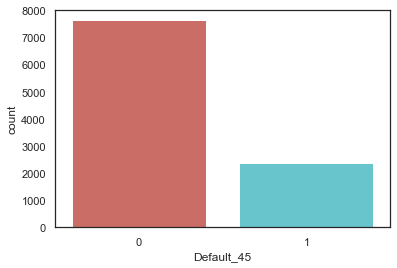

0    7636
1    2364
Name: Default_45, dtype: int64

In [15]:
#plotting label
data_plot(accept_data,"Default_45")
accept_data["Default_45"].value_counts()

# Business Channel vs Default

There are 3 different business channels. Below you can find the number of customers belonging to different channels wrt Default. Most of the customers belong to business channel 1

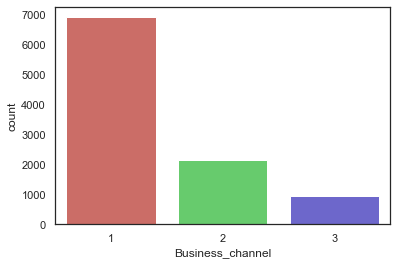

1    6912
2    2144
3     944
Name: Business_channel, dtype: int64

In [16]:
#plotting label
data_plot(accept_data,"Business_channel")
accept_data["Business_channel"].value_counts()

# Age vs Business Channel

Below graphs show the distribution of Age wrt the business channels and the number of defaulters 

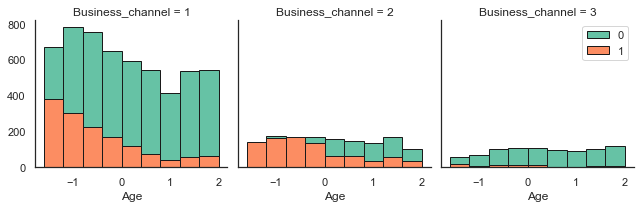

In [17]:
#plotting age over loan category and label
bins = np.linspace(accept_data.Age.min(), accept_data.Age.max(), 10)
g = sns.FacetGrid(accept_data, col="Business_channel", hue="Default_45", palette="Set2", col_wrap=3)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Correlation

Few variables have a significant correlation between especially the anonymized variables them which can be later handled while selecting the features for our model

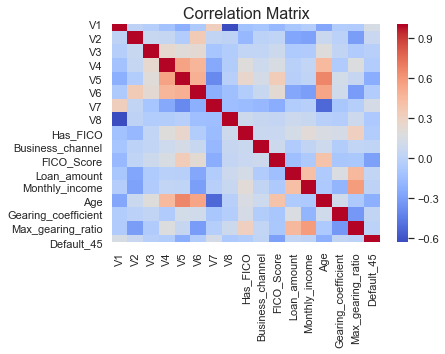

In [18]:
#correlation 
num_corr = accept_data.corr()
sns.heatmap(num_corr, cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix", fontsize=16,)
plt.show()

# Distribution of loan amount

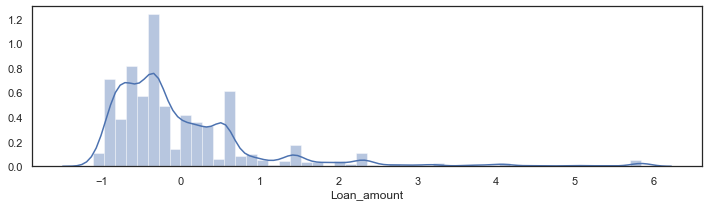

In [19]:
#Distribution of Loan Amount
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(accept_data['Loan_amount'])

# Distribution of Monthly Income

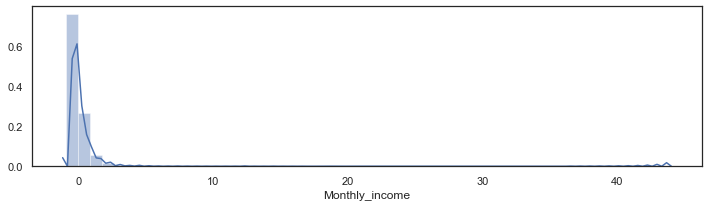

In [20]:
#Distribution of Monthly Income
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(accept_data['Monthly_income'])

# Loan vs Monthly Income

It would be ideal to see the spread of the data wrt loan amount and monthly income. We can observe by the scatter plot, most of the customers have low monthly income

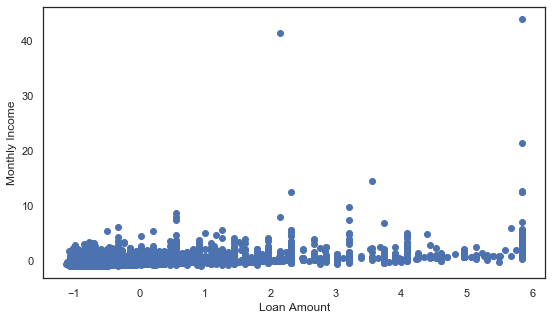

In [21]:
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(accept_data['Loan_amount'],accept_data['Monthly_income'])
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Monthly Income')
plt.show()

# WOE

We will try to get the Weight of evidence for each variable wrt target variable on the accepts data set. The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. This is a benchmark to screen variables in the credit risk model such as probability of default. It helps us to explore data and screen variables.

In [22]:
#split into train and validation
train, validation = train_test_split(accept_data, test_size=0.30, random_state = 1)

Train

In [23]:
#get the woe for train
features = list(train.columns)
features.remove('Default_45')
woe_map = WOEEncoder(cols=features).fit(train, train['Default_45'])
train_set = woe_map.transform(train)

In [24]:
train_set[features].head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
267817,0.088720,0.284703,0.338596,0.277962,-0.298049,0.417935,0.347647,-0.305746,-0.104843,-1.113025,1.645908,0.000000,0.172602,0.277962,1.153431,0.123293
289379,0.551488,0.106659,0.527725,0.135091,0.096400,0.417935,0.347647,-0.305746,-0.104843,-0.175561,-0.520545,0.211388,0.237140,0.035401,-0.792479,-0.037791
265845,0.088720,0.284703,-0.355874,-0.785580,-0.782223,-0.835913,-0.276549,0.339190,0.121052,-0.175561,0.120375,0.155660,0.460284,-0.870951,0.306133,-0.037791
265600,0.551488,0.106659,0.109423,0.277962,0.096400,0.417935,-0.276549,0.339190,-0.104843,-0.175561,0.000000,0.491056,1.558896,0.712459,0.000000,-0.032814
289457,-0.335254,0.106659,-0.355874,-0.160451,0.096400,0.417935,-0.276549,-0.305746,0.121052,-0.175561,0.120375,-0.285507,-0.099332,0.395145,0.460284,-0.037791


Validation

In [25]:
#get the woe for validation
features = list(validation.columns)
features.remove('Default_45')
woe_map = WOEEncoder(cols=features).fit(validation, validation['Default_45'])
val_set = woe_map.transform(validation)

In [26]:
val_set[features].head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
305474,-0.307406,0.099838,0.402878,-0.025034,0.620744,-0.094525,0.373503,-0.279254,-0.079666,-0.180440,0.926126,-0.317668,0.000000,-0.395630,1.906955,-0.034069
278297,0.594249,0.350479,0.341192,0.266824,-0.810574,0.469236,0.373503,0.351584,0.096013,-0.180440,0.095074,0.012163,0.115196,0.159647,0.000000,0.122978
284024,0.594249,0.099838,0.115196,0.266824,-0.342986,-0.237025,0.373503,0.351584,-0.079666,0.752043,1.619273,0.115196,0.000000,0.460036,0.000000,-0.043148
278610,-0.307406,-0.320765,-0.333398,-0.837463,-0.869303,-0.876444,-0.275786,-0.279254,0.096013,-0.180440,0.095074,0.134998,0.520661,-0.556898,0.000000,-0.034069
287120,0.594249,0.099838,0.074922,0.266824,0.270924,-0.094525,0.373503,0.351584,0.096013,-0.180440,0.095074,-0.080919,1.213808,0.352326,0.000000,-0.034069


# Feature Importance

Let's get the top 15 variables for our model by fiting the data to light gradient boosting algorithm and get the feature importance from the model.

In [27]:
#we create a seed for consistency. This will be used by our algorithms.
np.random.seed(123)

In [28]:
len(features)

16

In [29]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(16)

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [30]:
# Fit the model twice to avoid overfitting
for i in range(2):
    # Train using early stopping
    model.fit(train_set[features], train_set["Default_45"], early_stopping_rounds=500, eval_set = [(val_set[features], val_set["Default_45"])], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.909544	valid_0's binary_logloss: 0.414571
[400]	valid_0's auc: 0.904896	valid_0's binary_logloss: 0.419143
Early stopping, best iteration is:
[63]	valid_0's auc: 0.920412	valid_0's binary_logloss: 0.430073
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.909544	valid_0's binary_logloss: 0.414571
[400]	valid_0's auc: 0.904896	valid_0's binary_logloss: 0.419143
Early stopping, best iteration is:
[63]	valid_0's auc: 0.920412	valid_0's binary_logloss: 0.430073


In [31]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [32]:
feature_importances

,feature,importance
12,Monthly_income,330.0
14,Gearing_coefficient,309.0
10,FICO_Score,230.0
13,Age,196.0
11,Loan_amount,195.0
2,V3,104.0
4,V5,84.0
1,V2,77.0
9,Business_channel,64.0
3,V4,61.0


Selecting only the top 15 features

In [33]:
#through running a model and getting the features
selectedFeatures = feature_importances.iloc[:15,0]
#assign target
target = "Default_45"

# Model

This is a setup to initiate few selected models and fit the data. Let's use AUC and Accuracy as the metrics to assess the performance of the model.

In [34]:
randomForest = RandomForestClassifier()
neighbors    = KNeighborsClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter=1000)
catboost = CatBoostClassifier(task_type = 'CPU',verbose=False)

In [35]:
models = {"logistic"     :logistic,
          "randomForest" :randomForest,
          "neighbors"    :neighbors,
          "catboost" : catboost
         }

In [36]:
#fitting the models
for model in models:
    models[model].fit(train_set[selectedFeatures],train_set[target])
    print(f"{model} has been trained successfully")

logistic has been trained successfully
randomForest has been trained successfully
neighbors has been trained successfully


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


catboost has been trained successfully


In [37]:
performances_training = {}

for model in models:
    predictions   = models[model].predict(train_set[selectedFeatures])
    probabilities = pd.DataFrame(models[model].predict_proba(train_set[selectedFeatures]))[1]
    accuracy      = accuracy_score(train_set[target],predictions)
    auc           = roc_auc_score(np.array(train_set[target]),np.array(probabilities))
    
    performances_training[model] = {"Accuracy":accuracy,"AUC":auc}

Below is the performance of the models on the training set

In [38]:
pd.DataFrame(performances_training)

,logistic,randomForest,neighbors,catboost
Accuracy,0.856429,0.987429,0.882143,0.926857
AUC,0.897973,0.999577,0.937377,0.972469


In [39]:
performances = {}

for model in models:
    predictions   = models[model].predict(val_set[selectedFeatures])
    probabilities = pd.DataFrame(models[model].predict_proba(val_set[selectedFeatures]))[1]
    accuracy      = accuracy_score(val_set[target],predictions)
    auc           = roc_auc_score(np.array(val_set[target]),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

Below is the performance of the models on the validation set

In [40]:
pd.DataFrame(performances)

,logistic,randomForest,neighbors,catboost
Accuracy,0.855333,0.84000,0.825667,0.864333
AUC,0.901245,0.86552,0.825074,0.920878


Based on the performance of the models on the validation set. Although we didn't tune the parameters of the models. For our convenience, let's pick 2 best models and tune them.

Here in this case we choose the Logistic regression model and catboost model.

We will be using the catboost model to predict the Default status in the rejected datasets and logistic regression for getting the coefficients to generate the score for scorecard.

# Hyperparameter Tuning

Let's tune the model by find the best hyper parameters of the model. We will do a randomized grid search.

randomized grid search for catboost

In [41]:
#CB_grid = CatBoostClassifier(eval_metric = 'AUC',loss_function='Logloss',task_type = 'CPU',verbose = False)
#grid = {'learning_rate': [0.03,0.1,0.2,0.05], 
        #'depth': [5,6,7,8,9,10,11,12], 
        #'iterations' : range(100,1000,100), 
        #'l2_leaf_reg': [4,5,6,7,8,9]}

#randomized_search_result = CB_grid.randomized_search(grid, X=train_set[selectedFeatures], y=train_set[target], plot=True)

In [42]:
#randomized_search_result['params']
#{'depth': 6, 'l2_leaf_reg': 8, 'iterations': 900, 'learning_rate': 0.05}

# Best Model

Let's apply the best parameters and run the model.

Below we can find the evaluation of our model with different metrics.

In [43]:
cb = CatBoostClassifier(custom_metric=['TotalF1'], l2_leaf_reg = 8,early_stopping_rounds=100,depth = 6, iterations = 900, learning_rate = 0.05, eval_metric='AUC',verbose=False)

cb.fit(train_set[selectedFeatures], train_set[target],
          eval_set=(val_set[selectedFeatures], val_set[target]), plot=True, verbose=False, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Feature importance of our model. 

Gearing coefficient, Monthly Income, Fico Score has the highest importance

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

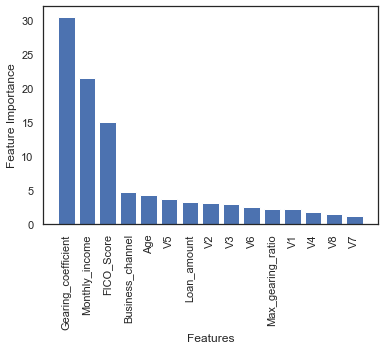

In [44]:
feat_imp=cb.get_feature_importance(prettified=True)
plt.bar(feat_imp['Feature Id'], feat_imp['Importances'])
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)

Function for getting the plots for ROC plot and precision,recall plot

In [45]:
#function for various metrics
def performance(model, X_test, y_test):
    
    """
    Accepts a fitted model and an evaluation dataset at input.
    Prints the confusion matrix, classification_report & auc score. 
    Also, displays Precision-Recall curve & ROC curve.
    """
    print(model)
    # Make predictions on test set
    y_pred=model.predict(X_test)
    y_pred=np.round(y_pred)

    # Confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # AUC score
    y_pred_prob = model.predict_proba(X_test)
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob[:,1]))

    # Logloss
    print("Logloss : ", log_loss(y_test, y_pred_prob))

    # Accuracy, Precision, Recall, F1 score print(classification_report(y_test, y_pred))
    
      # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    plt.plot([0, 1], [0, 1],'k--')
    plt.plot(fpr, tpr, label='Neural Network')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()
    print("***********************----------------------------*************************")

Below you can find the ROC plot and Precision vs Recall Plot on the validation set

[[2138  176]
 [ 225  461]]
AUC score:  0.9250631849233087
Logloss :  0.2996268398591551


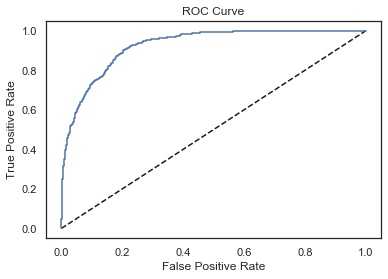

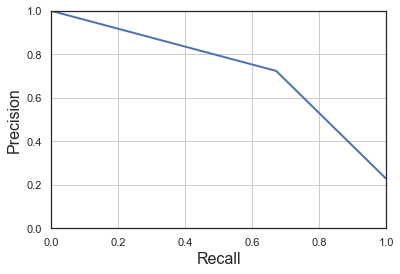

***********************----------------------------*************************


In [46]:
performance(cb, val_set[selectedFeatures], val_set["Default_45"])

# Cross Validation

Function for performing cross validation

In [47]:
def cv_fit(alg, dtrain, predictors, performCV=True,cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    
    print ("\nModel Report: ",alg)
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print("\n-----------------------------------********************-----------------------------------\n")

The cv score is also good, which means the model did not overfit to the train set 

In [48]:
cv_fit(cb,train_set,selectedFeatures)


Model Report:  <catboost.core.CatBoostClassifier object at 0x000002694D94B288>
Accuracy : 0.9483
AUC (Train): 0.985026
CV Score : Mean - 0.9079732 | Std - 0.00861213 | Min - 0.8921243 | Max - 0.9157614

-----------------------------------********************-----------------------------------



# Reject Inference

The Reject Inference Method helps us to improve the quality of our scorecard by including the data from rejected applications. This method helps us to handle the bias in the model because we only consider the accepts data. Bias can result if a credit scorecard model is built only on accepts and does not account for applications rejected because of past denials for credit or unknown nondefault status. By using the reject inference method, you can infer the performance of rejects and include them in your credit scorecard model to remedy this bias.

In order to get the Default status in the rejects dataset, we will be using the catboost model which we trained on the accepts data.

In [49]:
#predict deafult status on reject dataset
preds = cb.predict(reject_data[selectedFeatures])

In [50]:
#add the deafult column in reject dataset
reject_data['Default_45'] = preds

In order to improve the quality of scorecard, we shall concat both the datasets and build the scorecard in order to avoid bias as discussed earlier.

In [51]:
#concatenate both the datasets 
data = pd.concat([accept_data, reject_data])

Calculate the WOE on the whole dataset

In [52]:
#WOE on the concatenated dataset
woe_map = WOEEncoder(cols=features).fit(data, data['Default_45'])
data = woe_map.transform(data)

In [53]:
data[features].head()

,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
ID,,,,,,,,,,,,,,,,
250263,-0.091946,0.063371,-0.318277,-0.502810,0.038639,-0.542649,-0.077559,-0.094829,-0.097394,-0.075336,-0.057145,0.699820,0.019577,-0.211349,1.405871,-0.050174
250290,-0.091946,0.096607,0.203462,0.182872,0.004978,-0.089838,-0.077559,-0.094829,0.072730,-0.075336,0.211948,0.359191,1.000406,-0.643718,0.000000,0.267922
250249,-0.333152,0.048260,-0.318277,-0.502810,-0.499270,-0.542649,-0.077559,-0.094829,0.072730,-0.075336,0.429861,-0.473007,-0.098206,-0.206420,0.643731,-0.084393
249516,0.196756,0.048260,0.174453,0.182872,0.259697,0.055427,-0.077559,-0.094829,-0.097394,-0.075336,-0.057145,-0.431768,1.000406,-0.133797,0.000000,-0.050174
249827,-0.091946,0.048260,-0.186275,0.057829,-0.084953,0.055427,-0.077559,-0.016393,-0.097394,-0.075336,-0.057145,0.162077,0.749091,0.179745,-0.385889,-0.084393


# Train and Test on Final Dataset

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data[selectedFeatures], data[target], test_size=0.3, random_state=123)

We shall use Logistic Regression Algorithm in order to get the regression coefficients

In [55]:
logfit = logistic.fit(X_train,y_train)

In [56]:
coefficients = pd.concat([pd.DataFrame(data[selectedFeatures].columns),pd.DataFrame(np.transpose(logfit.coef_))], axis = 1)
coefficients.columns = ['Feature','cf']
coefficients

,Feature,cf
0,Monthly_income,1.410288
1,Gearing_coefficient,1.775350
2,FICO_Score,0.871234
3,Age,0.551833
4,Loan_amount,0.779352
5,V3,0.374415
6,V5,0.544060
7,V2,0.507432
8,Business_channel,0.536525
9,V4,-0.535596


# Scorecard

When scaling the model into a scorecard, we will need both the Logistic Regression coefficients from model fitting as well as the transformed WoE values. We will also need to convert the score from the model from the log-odds unit to a points system

In [57]:
coefficients = coefficients.set_index('Feature')

In [58]:
scorecard_train = X_train[coefficients.index].apply(lambda x: x*coefficients['cf'].T,axis=1)

In [59]:
scorecard_train['Default_45'] = y_train

In [60]:
scorecard_train['logit'] = scorecard_train[list(scorecard_train.columns)].sum(axis=1)

For each independent variable, its corresponding score is:

Score_i= (βi × WoE_i + α/n) × Factor + Offset/n

Where:

βi — logistic regression coefficient for the variable Xi

α — logistic regression intercept

WoE — Weight of Evidence value for variable Xi

n — number of independent variable Xi in the model

Factor, Offset — known as scaling parameter, where

Factor = pdo/ln(2)

Offset = Target Score — (Factor × ln(Target Odds))

Function for generating scores

In [61]:
targetscore = 900
odds = 30
double_odds = 20

factor = double_odds/np.log(2)
offset = targetscore - factor * np.log(odds)

In [62]:
scorecard_train['score'] = offset + factor * scorecard_train['logit']

In [63]:
scorecard_train.head()

,Monthly_income,Gearing_coefficient,FICO_Score,Age,Loan_amount,V3,V5,V2,Business_channel,V4,V1,V6,V8,Max_gearing_ratio,V7,Default_45,logit,score
ID,,,,,,,,,,,,,,,,,,
286378,-1.333433,1.379913,-0.049787,-0.314057,-0.336500,-0.119168,-0.271633,0.024489,-0.04042,0.269303,-0.161594,-0.080892,0.020942,0.030531,0.001486,0,-0.980819,773.561721
316569,-0.710322,-1.500918,0.073284,-0.350932,0.274496,-0.119168,-0.271633,-0.098329,-0.04042,0.269303,-0.044598,-0.080892,-0.022056,0.030531,0.001486,0,-2.590168,727.125740
293701,-0.138499,-1.404930,-0.530609,-0.329142,-0.368639,-0.119168,-0.271633,0.032156,-0.04042,0.269303,0.095436,-0.080892,0.020942,0.018151,0.001486,0,-2.846457,719.730789
316515,1.410860,-0.174351,0.457382,0.099189,0.274496,0.119119,0.031349,-0.098329,-0.04042,-0.097945,0.095436,0.021849,-0.003813,-0.096926,-0.001788,1,2.996108,888.311597
316295,0.298908,0.000000,-1.163070,0.010803,-0.368639,-0.119168,-0.271633,0.032156,-0.04042,0.269303,-0.044598,-0.080892,-0.022056,0.030531,0.001486,0,-1.467287,759.525226


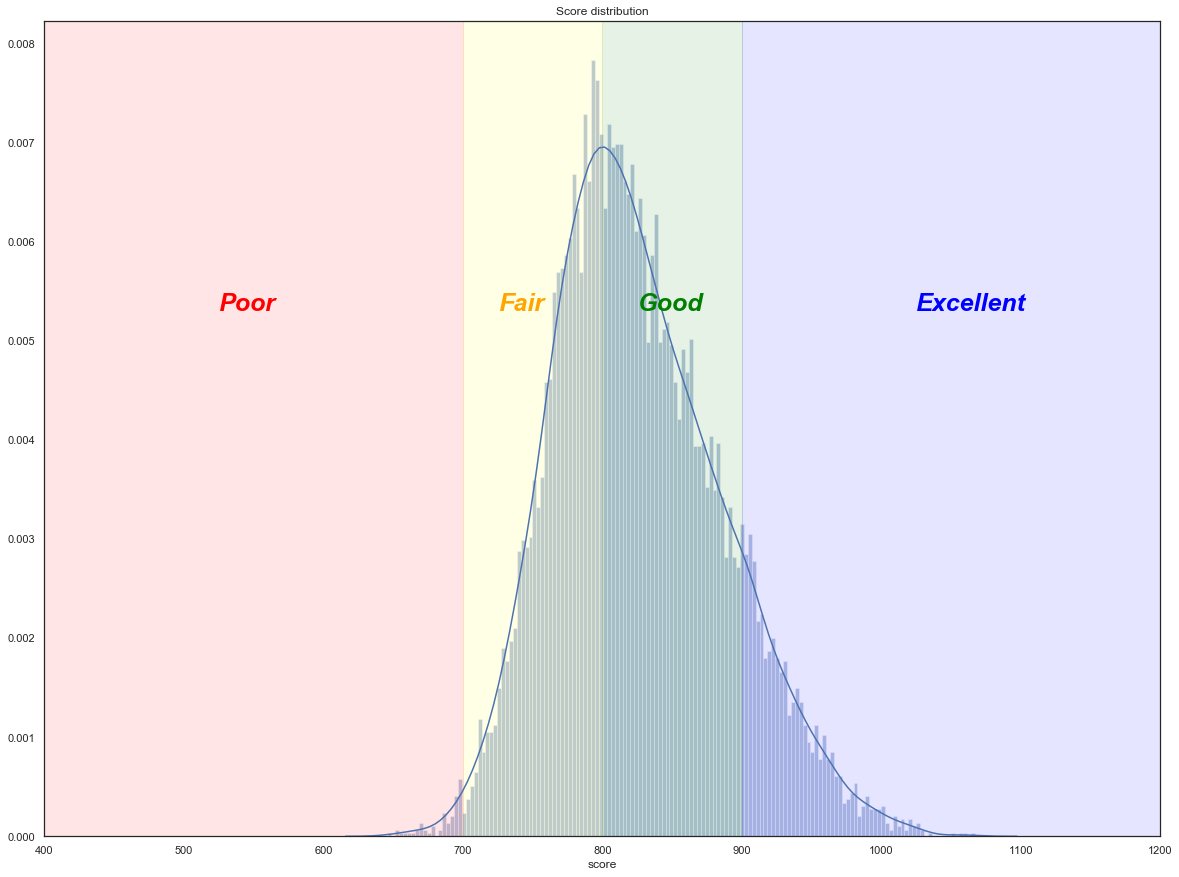

In [64]:
f, axes = plt.subplots(figsize=(20, 15))
plt.xlim(400,1200)
sns.distplot(scorecard_train['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700, 800, alpha=0.1, color='yellow')
plt.axvspan(800, 900, alpha=0.1, color='green')
plt.axvspan(900, 1200, alpha=0.1, color='blue')
plt.text(525, 0.0053, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.0053, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.0053, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.0053, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score distribution')
plt.show()

# Test

Test the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[3033  300]
 [ 538  629]]
AUC score:  0.8523186508882251
Logloss :  0.4048882433638175


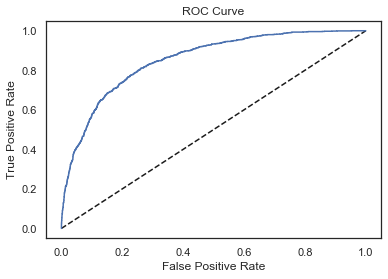

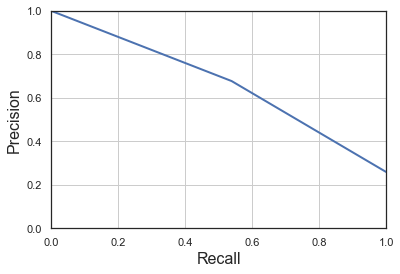

***********************----------------------------*************************


In [65]:
performance(logistic,X_test,y_test)

In [66]:
def scorecard(data, model):
    coefficients = pd.concat([pd.DataFrame(data[selectedFeatures].columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coefficients.columns = ['Feature','Coef']
    coefficients = coefficients.set_index('Feature')
    
    scorecard = data[coefficients.index].apply(lambda x: x*coefficients['Coef'].T,axis=1)

    scorecard['logit'] = scorecard[list(scorecard.columns)].sum(axis=1)

    ## Score card:

    target_score = 900
    target_odds = 30
    pts_double_odds = 20

    factor = pts_double_odds/np.log(2)
    offset = target_score - factor * np.log(target_odds)

    scorecard['score'] = offset + factor * scorecard['logit']
    return scorecard

In [67]:
scorecard_test = scorecard(X_test, logistic)

In [68]:
scorecard_test.head()

,Monthly_income,Gearing_coefficient,FICO_Score,Age,Loan_amount,V3,V5,V2,Business_channel,V4,V1,V6,V8,Max_gearing_ratio,V7,logit,score
ID,,,,,,,,,,,,,,,,,
293833,0.762787,1.776070,-0.049787,0.075251,0.279937,0.016632,0.099666,0.024489,-0.040420,-0.055554,0.095436,0.008262,0.020942,0.030531,-0.001788,3.042456,889.648903
296365,-0.229517,1.502399,-0.049787,0.106133,0.342803,0.016632,0.099666,0.032689,-0.040420,-0.030973,-0.044598,0.021849,0.005399,0.030531,-0.001788,1.761020,852.674474
272604,0.433323,1.056228,0.175900,-0.164278,-0.003256,-0.119168,0.021022,0.024489,0.346406,-0.097945,-0.044598,0.008262,-0.003813,0.018151,0.001486,1.652210,849.534888
278528,0.000000,0.000000,-0.530609,0.161130,-0.257058,0.089649,-0.046220,0.032156,-0.040420,-0.030973,0.095436,0.008262,0.020942,-0.096926,0.001486,-0.593144,784.747656
300098,-0.384388,-1.081245,-0.049787,0.141250,-0.221985,0.016632,0.099666,0.032689,-0.040420,0.038136,0.041078,0.008262,0.020942,0.030531,-0.001788,-1.350425,762.897166


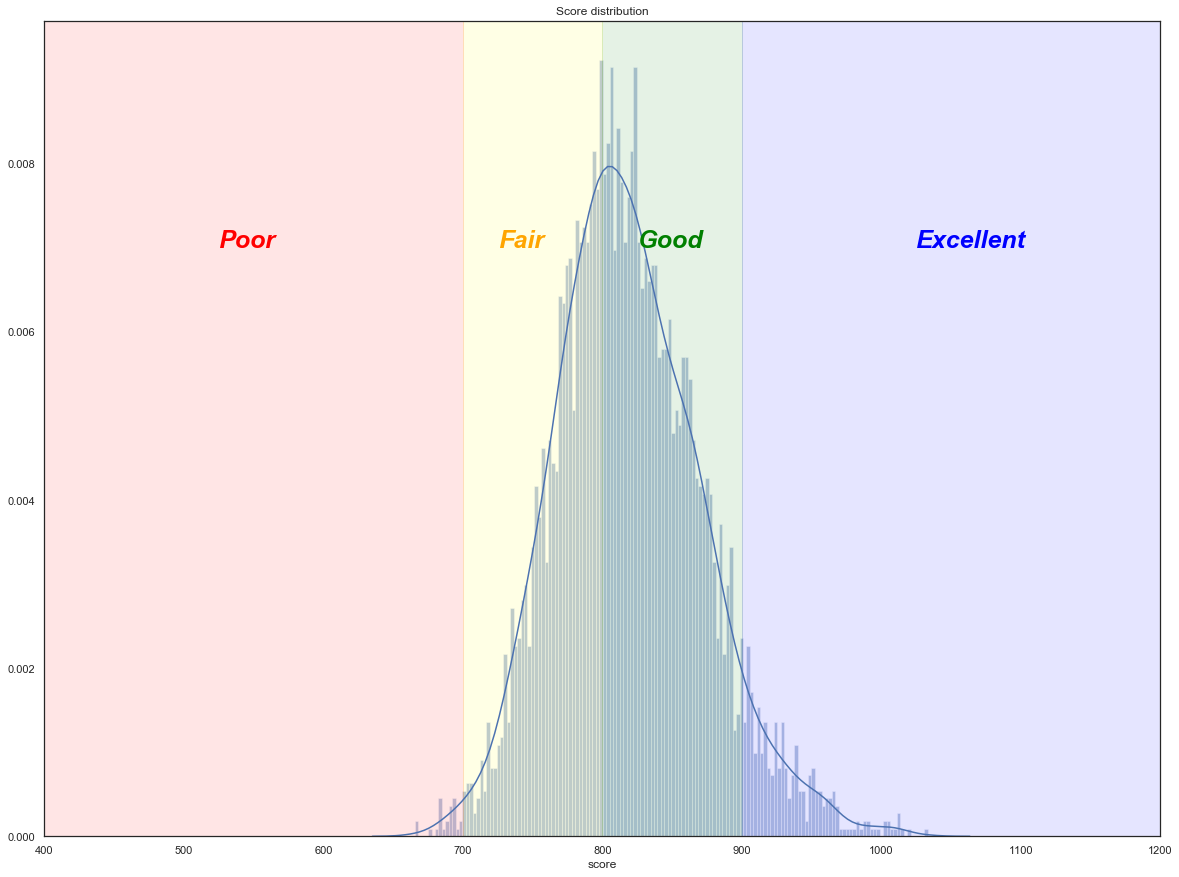

In [69]:
f, axes = plt.subplots(figsize=(20, 15))
plt.xlim(400,1200)
sns.distplot(scorecard_test['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700, 800, alpha=0.1, color='yellow')
plt.axvspan(800, 900, alpha=0.1, color='green')
plt.axvspan(900, 1200, alpha=0.1, color='blue')
plt.text(525, 0.007, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.007, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.007, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.007, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score distribution')
plt.show()

# Final

Finally, we fit the model on the whole dataset and get the scores. In reality we will use the trained and tested model for predicting the scores.

In [70]:
logreg = LogisticRegression().fit(data[selectedFeatures], data[target])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
scorecardFinal = scorecard(data, logreg)
scorecardFinal.head()

,Monthly_income,Gearing_coefficient,FICO_Score,Age,Loan_amount,V3,V5,V2,Business_channel,V4,V1,V6,V8,Max_gearing_ratio,V7,logit,score
ID,,,,,,,,,,,,,,,,,
250263,0.027433,2.476408,-0.047551,-0.090147,0.535678,-0.100902,0.024981,0.030413,-0.038396,0.310739,-0.035537,-0.107101,-0.014628,0.017856,-0.017828,2.971417,887.599161
250290,1.401879,0.000000,0.176365,-0.274566,0.274943,0.064503,0.003218,0.046363,-0.038396,-0.113016,-0.035537,-0.017731,-0.014628,-0.095348,-0.017828,1.360223,841.109921
250249,-0.137618,1.133916,0.357693,-0.088045,-0.362063,-0.100902,-0.322790,0.023161,-0.038396,0.310739,-0.128761,-0.107101,-0.014628,0.030034,-0.017828,0.537411,817.368584
249516,1.401879,0.000000,-0.047551,-0.057069,-0.330497,0.055306,0.167900,0.023161,-0.038396,-0.113016,0.076045,0.010939,-0.014628,0.017856,-0.017828,1.134102,834.585453
249827,1.049710,-0.679733,-0.047551,0.076667,0.124062,-0.059054,-0.054924,0.023161,-0.038396,-0.035739,-0.035537,0.010939,-0.002529,0.030034,-0.017828,0.343282,811.767201


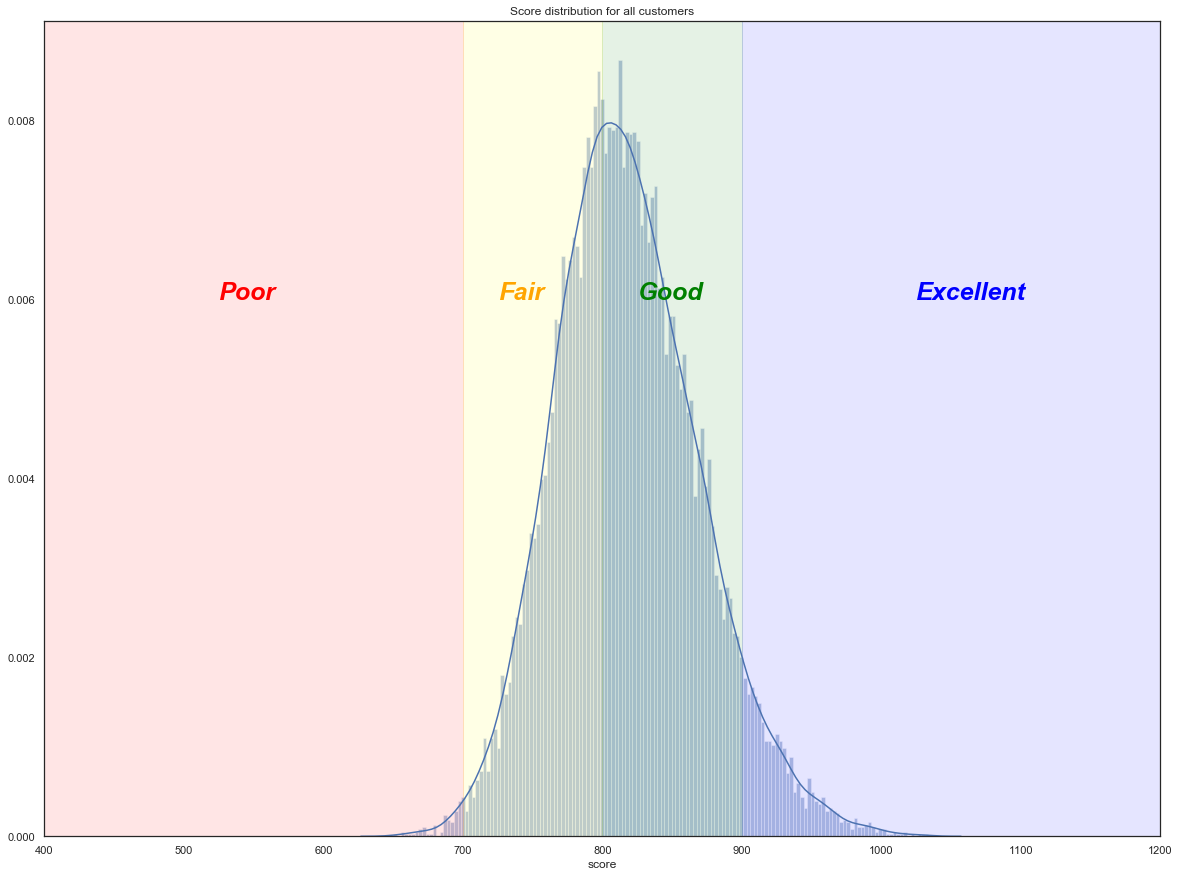

In [72]:
f, axes = plt.subplots(figsize=(20, 15))
plt.xlim(400,1200)
sns.distplot(scorecardFinal['score'], bins = 150)
plt.axvspan(400,700, alpha=0.1, color='red')
plt.axvspan(700, 800, alpha=0.1, color='yellow')
plt.axvspan(800, 900, alpha=0.1, color='green')
plt.axvspan(900, 1200, alpha=0.1, color='blue')
plt.text(525, 0.006, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(725, 0.006, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(825, 0.006, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(1025, 0.006, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score distribution for all customers')
plt.show()

# Survival Analysis

To analyze the defaulters on a lifetime basis, we will use Kaplan Meier method to develop Survival Analysis. Tha advantage of survival models is it not only predicts whether the customer defaults or not but also the time when the default occurs.

In [73]:
#pip install lifelines

In [74]:
from lifelines import KaplanMeierFitter

In [75]:
#read in the data
accept_data = pd.read_excel("ACCEPTS.xlsx",sheet_name = 'Dataset')

X = Number of days late

Y = Customers who default

In [76]:
kmf =  KaplanMeierFitter()
X = accept_data.loc[accept_data['Default_45'] == 1, 'Days_late']
Y = accept_data.loc[accept_data['Default_45'] == 1, 'Default_45']

Fit the data.

In [77]:
kmf.fit(X,Y)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2364 total observations, 0 right-censored observations>

With the below curve we can predict the probability of a customer to default based on the days late.

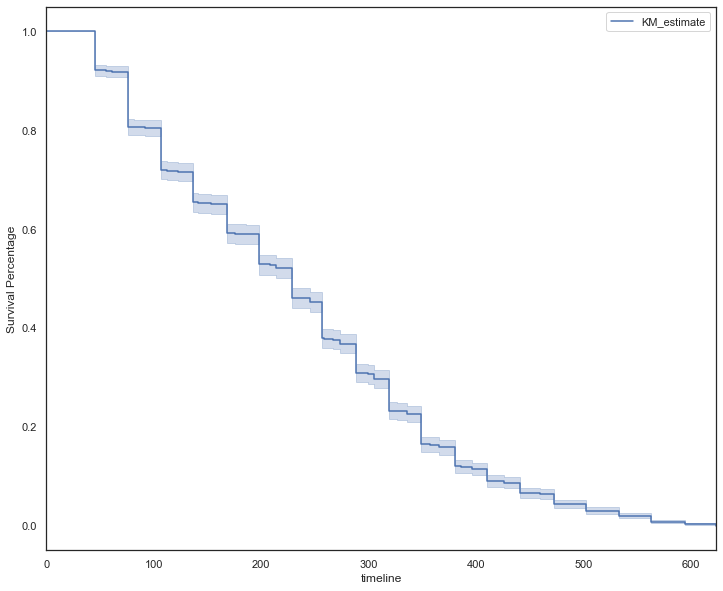

In [78]:
f, axes = plt.subplots(figsize=(12, 10))
plt.ylabel('Survival Percentage')
kmf.plot()